In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.CPPN1 import CPPN1training
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 100
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
print(len(list(cppn1.children())))

4


In [6]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [7]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []
layer_count = len(list(cppn1.children()))


def normalize(tensor, axis):
    if axis % 2 == 0:
        max_vals = layer_count
        min_vals = 0
    else:
        max_vals, _ = torch.max(tensor, dim=0)
        min_vals, _ = torch.min(tensor, dim=0)

    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
        normal = temp_coords
        print(temp_coords)
        for i in range(4):
            # print(i)
            normal[:,i] = normalize(temp_coords[:, i], i)
            # normal = torch.nan_to_num(normal, nan = 0)
        if index == 3:
            # print(temp_coords)
            print(normal)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)

# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

        

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  0.,  1.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  2.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  0.,  1.,  3.],
        [ 0.,  1.,  1.,  3.],
        [ 0.,  0.,  1.,  4.],
        [ 0.,  1.,  1.,  4.],
        [ 0.,  0.,  1.,  5.],
        [ 0.,  1.,  1.,  5.],
        [ 0.,  0.,  1.,  6.],
        [ 0.,  1.,  1.,  6.],
        [ 0.,  0.,  1.,  7.],
        [ 0.,  1.,  1.,  7.],
        [ 0.,  0.,  1.,  8.],
        [ 0.,  1.,  1.,  8.],
        [ 0.,  0.,  1.,  9.],
        [ 0.,  1.,  1.,  9.],
        [ 0.,  0.,  1., 10.],
        [ 0.,  1.,  1., 10.],
        [ 0.,  0.,  1., 11.],
        [ 0.,  1.,  1., 11.],
        [ 0.,  0.,  1., 12.],
        [ 0.,  1.,  1., 12.],
        [ 0.,  0.,  1., 13.],
        [ 0.,  1.,  1., 13.],
        [ 0.,  0.,  1., 14.],
        [ 0.,  1.,  1., 14.],
        [ 0.,  0.,  1., 15.],
        [ 0.,  1.,  1., 15.],
        [ 0.,  0.,  1., 16.],
        [ 

#### Set up CPPN_squared

In [8]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [9]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [10]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [11]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.7209, 0.3333, 0.7483,  ..., 0.5367, 0.5460, 0.5137], device='cuda:0')


#### Split training and validation set


In [12]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [13]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -0.5000, -1.0000],
        [-1.0000,  1.0000, -0.5000, -1.0000],
        [-1.0000, -1.0000, -0.5000, -0.9683],
        ...,
        [ 0.5000,  0.9365,  1.0000,  1.0000],
        [ 0.5000,  0.9683,  1.0000,  1.0000],
        [ 0.5000,  1.0000,  1.0000,  1.0000]], device='cuda:0')


In [14]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.020
Validation - Step 0, loss 0.020
step 1, loss 0.019
Validation - Step 1, loss 0.019
step 2, loss 0.018
Validation - Step 2, loss 0.018
step 3, loss 0.017
Validation - Step 3, loss 0.017
step 4, loss 0.016
Validation - Step 4, loss 0.016
step 5, loss 0.015
Validation - Step 5, loss 0.015
step 6, loss 0.014
Validation - Step 6, loss 0.014
step 7, loss 0.014
Validation - Step 7, loss 0.013
step 8, loss 0.013
Validation - Step 8, loss 0.012
step 9, loss 0.012
Validation - Step 9, loss 0.012
step 10, loss 0.011
Validation - Step 10, loss 0.011
step 11, loss 0.011
Validation - Step 11, loss 0.010
step 12, loss 0.010
Validation - Step 12, loss 0.009
step 13, loss 0.009
Validation - Step 13, loss 0.009
step 14, loss 0.009
Validation - Step 14, loss 0.008
step 15, loss 0.008
Validation - Step 15, loss 0.008
step 16, loss 0.008
Validation - Step 16, loss 0.007
step 17, loss 0.007
Validation - Step 17, loss 0.007
step 18, loss 0.007
Validation - Step 18, loss 0.006
step 19, loss

In [15]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.4954, 0.4979, 0.4954, 0.4981, 0.4953, 0.4983, 0.4952, 0.4984, 0.4952,
        0.4986, 0.4951, 0.4988, 0.4950, 0.4990, 0.4950, 0.4991, 0.4949, 0.4993,
        0.4948, 0.4994, 0.4947, 0.4996, 0.4947, 0.4998, 0.4946, 0.4999, 0.4945,
        0.5001, 0.4945, 0.5002, 0.4944, 0.5004, 0.4943, 0.5005, 0.4942, 0.5006,
        0.4942, 0.5008, 0.4941, 0.5009, 0.4940, 0.5010, 0.4940, 0.5012, 0.4939,
        0.5013, 0.4938, 0.5014, 0.4937, 0.5015, 0.4937, 0.5016, 0.4936, 0.5018,
        0.4935, 0.5019, 0.4934, 0.5020, 0.4934, 0.5021, 0.4933, 0.5022, 0.4932,
        0.5023, 0.4931, 0.5024, 0.4930, 0.5024, 0.4930, 0.5025, 0.4929, 0.5026,
        0.4928, 0.5027, 0.4927, 0.5028, 0.4926, 0.5028, 0.4926, 0.5029, 0.4925,
        0.5030, 0.4924, 0.5030, 0.4923, 0.5031, 0.4922, 0.5031, 0.4921, 0.5032,
        0.4920, 0.5032, 0.4920, 0.5033, 0.4919, 0.5033, 0.4918, 0.5034, 0.4917,
        0.5034, 0.4916, 0.5034, 0.4915, 0.5034, 0.4914, 0.5035, 0.4913, 0.5035,
        0.4913, 0.5035, 0.4912, 0.5035, 

In [16]:
print(all_pixel_values)

tensor([0.7209, 0.3333, 0.7483, 0.6510, 0.2238, 0.7850, 0.7045, 0.2162, 0.2346,
        0.7052, 0.3673, 0.3929, 0.5859, 0.4200, 0.1883, 0.2282, 0.5821, 0.1469,
        0.8489, 0.6233, 0.4986, 0.7789, 0.2714, 0.3786, 0.8362, 0.6427, 0.7117,
        0.2478, 0.3998, 0.2675, 0.5017, 0.5762, 0.4524, 0.6754, 0.4917, 0.5302,
        0.2995, 0.2996, 0.5733, 0.2902, 0.7097, 0.2594, 0.8340, 0.5308, 0.2269,
        0.1483, 0.6900, 0.2799, 0.7426, 0.8526, 0.1492, 0.7998, 0.4331, 0.1611,
        0.7289, 0.5847, 0.3369, 0.3226, 0.1898, 0.4291, 0.2495, 0.4096, 0.3354,
        0.7360, 0.2919, 0.1808, 0.8061, 0.6689, 0.5170, 0.2500, 0.7750, 0.2528,
        0.5547, 0.3566, 0.2246, 0.8396, 0.5251, 0.5572, 0.6270, 0.7880, 0.4867,
        0.6379, 0.2843, 0.5539, 0.1995, 0.6029, 0.3174, 0.7196, 0.5876, 0.4019,
        0.3762, 0.6549, 0.2869, 0.4258, 0.7596, 0.5276, 0.2909, 0.5542, 0.2337,
        0.5857, 0.7142, 0.3193, 0.4624, 0.4600, 0.3632, 0.6470, 0.7135, 0.1936,
        0.3378, 0.5656, 0.4191, 0.6351, 

Text(0.5, 1.0, 'target')

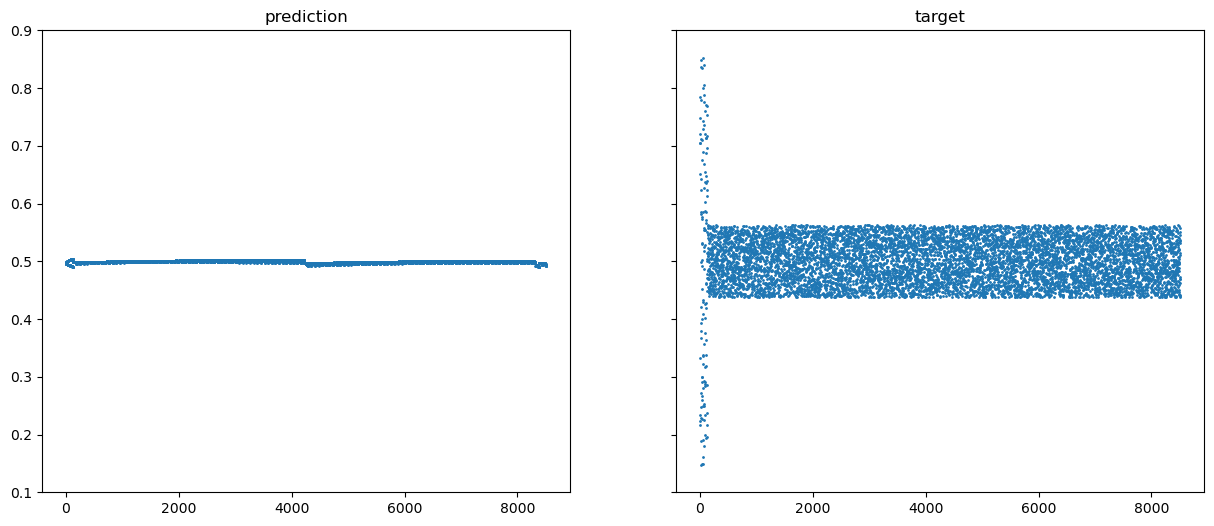

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [18]:
prediction.mul_(2).sub_(1)
index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

128
tensor([[-0.0091, -0.0042],
        [-0.0092, -0.0038],
        [-0.0094, -0.0035],
        [-0.0095, -0.0031],
        [-0.0097, -0.0028],
        [-0.0098, -0.0024],
        [-0.0099, -0.0021],
        [-0.0101, -0.0018],
        [-0.0102, -0.0014],
        [-0.0104, -0.0011],
        [-0.0105, -0.0008],
        [-0.0106, -0.0005],
        [-0.0108, -0.0002],
        [-0.0109,  0.0001],
        [-0.0111,  0.0004],
        [-0.0112,  0.0007],
        [-0.0114,  0.0010],
        [-0.0115,  0.0013],
        [-0.0116,  0.0016],
        [-0.0118,  0.0018],
        [-0.0119,  0.0021],
        [-0.0121,  0.0023],
        [-0.0122,  0.0026],
        [-0.0124,  0.0028],
        [-0.0125,  0.0031],
        [-0.0127,  0.0033],
        [-0.0128,  0.0035],
        [-0.0130,  0.0037],
        [-0.0131,  0.0039],
        [-0.0133,  0.0041],
        [-0.0134,  0.0043],
        [-0.0136,  0.0045],
        [-0.0138,  0.0047],
        [-0.0139,  0.0049],
        [-0.0141,  0.0051],
        [-0.0142